In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import json

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [2]:
sns.set(rc={"figure.figsize": (18, 6), 'legend.fontsize': 18}) # figsize and leg fontsize of seaborn plots
plt.rc('axes' , labelsize=18)                                  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('axes' , titlesize=18) 

# Part 1 - Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [3]:
login=pd.read_json('logins.json')
login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
login.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [5]:
login.set_index('login_time', inplace=True)
login['login']=1

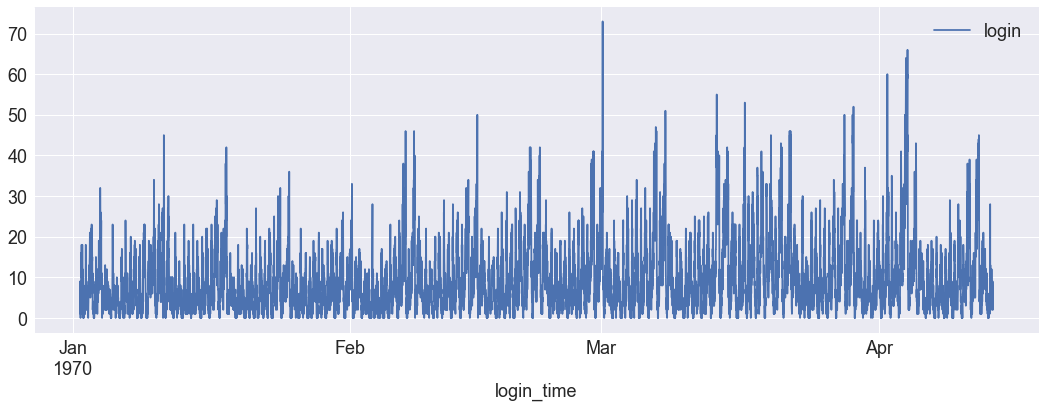

In [6]:
login.resample('15T').sum().plot()
plt.show()

Zoom in to see one month trend.

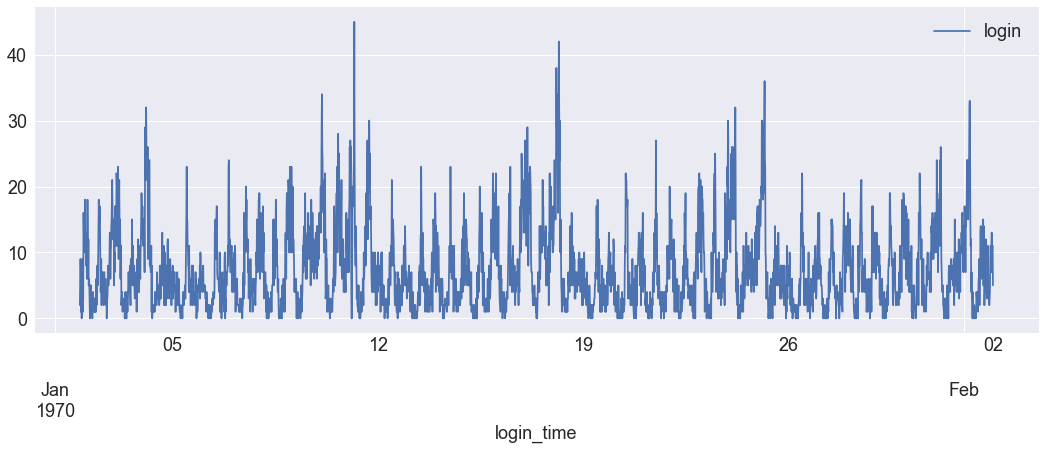

In [7]:
login.resample('15T').sum()['1970-01-01':'1970-02-01'].plot()
plt.show()

zoom in to see one week trend.

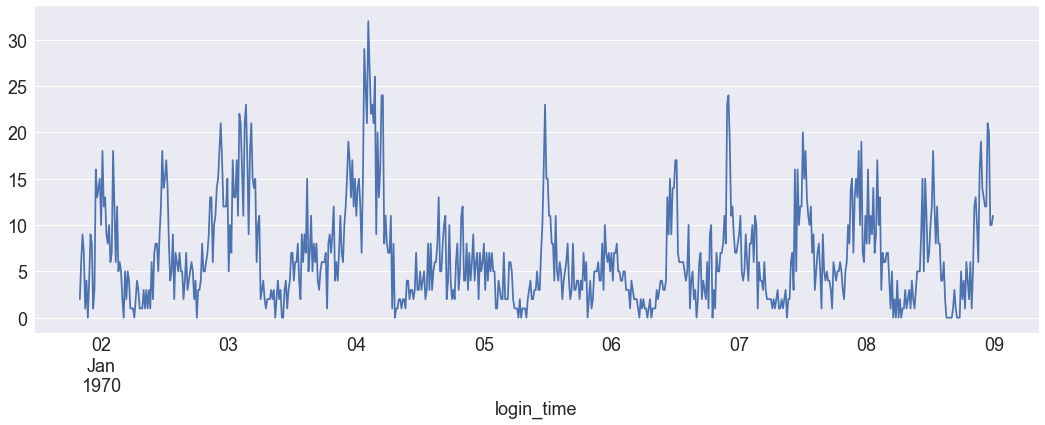

In [8]:
login.resample('15T')['login'].sum()['1970-01-01':'1970-01-08'].plot()
plt.show()

We can see there is 12 hour pattern in the data. 

Text(0.5,1,'all Mondays')

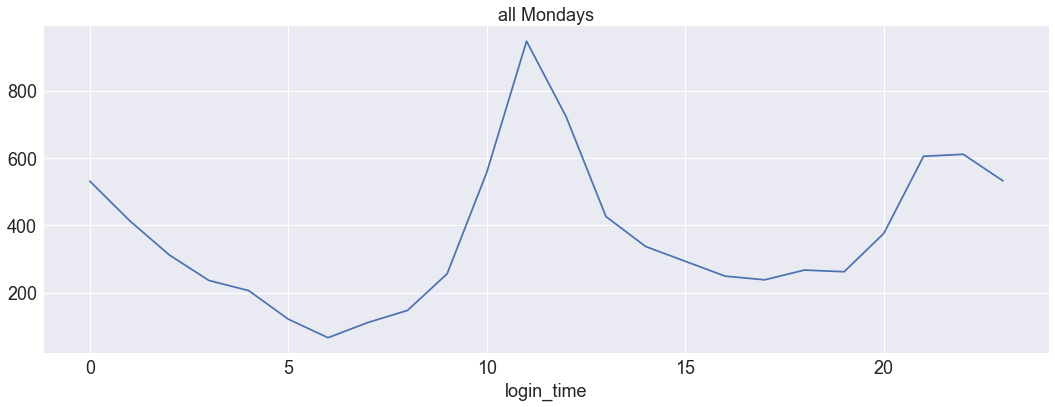

In [9]:
monday=login[login.index.dayofweek==0].resample('15T')['login'].sum()
monday.groupby(monday.index.hour).sum().plot()
plt.title('all Mondays')

Text(0.5,1,'all Tuesdays')

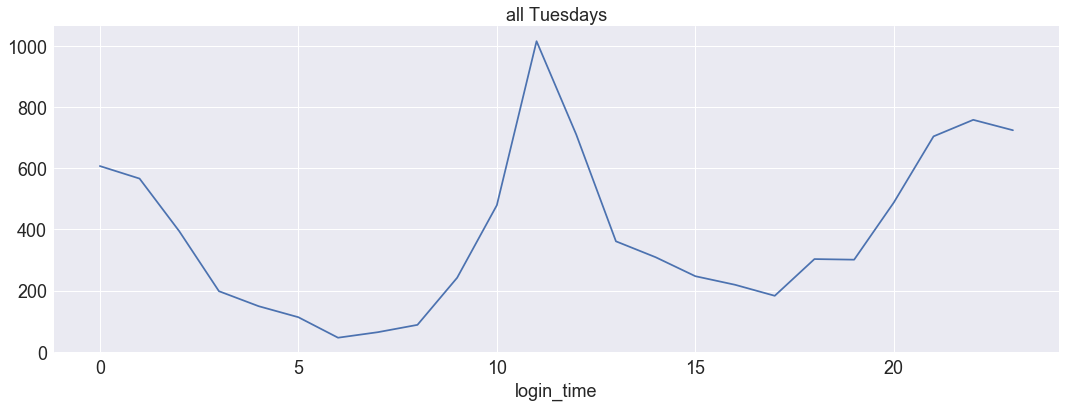

In [10]:
Tuesday=login[login.index.dayofweek==1].resample('15T')['login'].sum()
Tuesday.groupby(Tuesday.index.hour).sum().plot()
plt.title('all Tuesdays')

Text(0.5,1,'all Fridays')

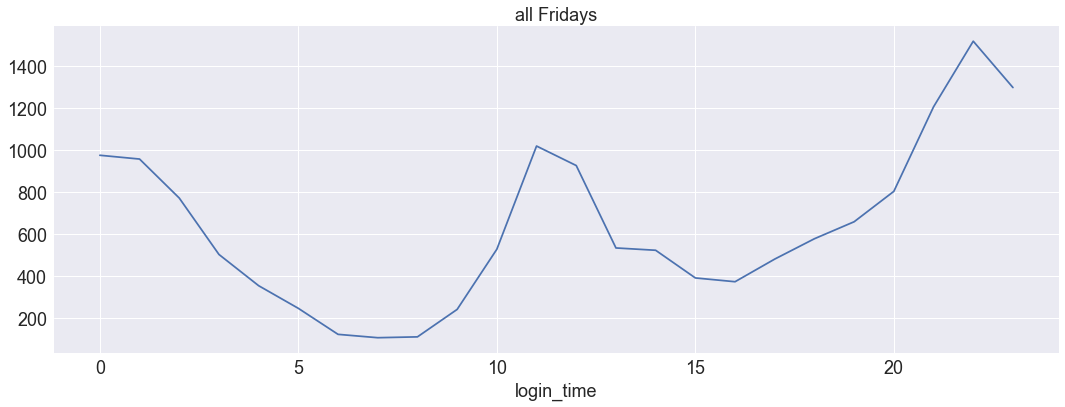

In [11]:
Friday=login[login.index.dayofweek==4].resample('15T')['login'].sum()
Friday.groupby(Friday.index.hour).sum().plot()
plt.title('all Fridays')

Text(0.5,1,'all Saturdays')

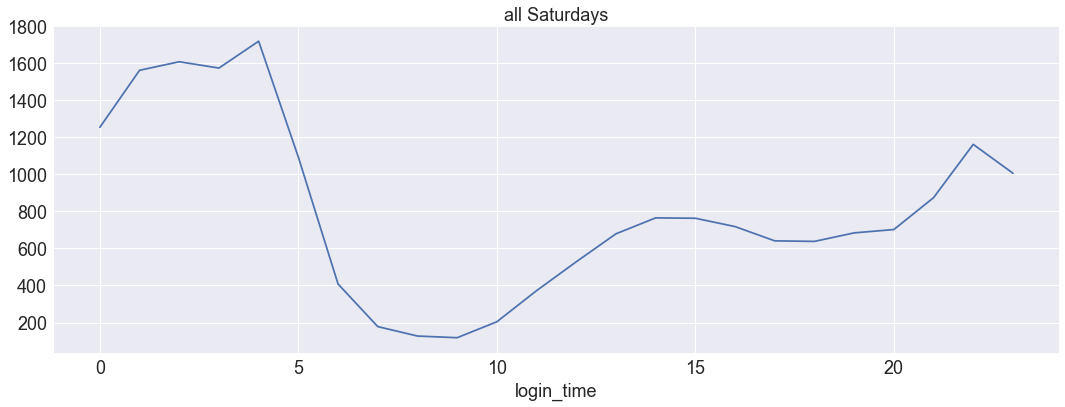

In [12]:
Sat=login[login.index.dayofweek==5].resample('15T')['login'].sum()
Sat.groupby(Sat.index.hour).sum().plot()
plt.title('all Saturdays')

In summary, during weekdays we see the 12 hour cycle where peak occur at noon and late night. However weekend follows a different pattern, where there are more trafiic at late night throughout until 4am.

# Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

'Answer': the goal of this proposal is hopefully getting drivers to make more rides by utilizing the complementary pattern of two neighboring cities. Therefore we can measure the number of rides in a day or in a week by a driver. When we are monitoring this metric, it's easy to note down where the activity happens (in their home city or neighbouring city) and not only we can see if overral rides increase due to toll reimbursement, but also if drivers are taking more rides at neighbouring city as we hope for.

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


'Answer': To design the experiment, first we need to decide the how to split for control and experiment group. Here we can't split by user b/c of the interaction in the market. If we reimburse users in control group, and result is what we hope for, then control group will end up having more rides which cause more competition to the users in experiment group, thus negatively affect their rides. Therefore we need to test by market. First, we will match two comparable markets in pairs, give drivers in one market reimbursement for toll fee and the other market no reimbursement. By comparable market we mean they have similiar pattern (two neighbouring cities have complementary activity pattern) and similiar average rides per driver each day if there were no test. Then we will decide the sample size needed. To identity required sample size, choose power, significance level, minimum difference b/t experiment and control. Then run the test, and check if the average rides per driver per day is significant b/t two groups. Let's say if the average rides per driver per day is significantly higher than control group, we can recommend to implement reimbursment policy b/c it shows it encourages drivers to have more rides.

# Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

In [13]:

with open('ultimate_data_challenge.json','r') as f:
    data=json.load(f)
    
data=pd.DataFrame(data)

In [14]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [15]:
data['signup_date']=pd.to_datetime(data.signup_date)
data['last_trip_date']=pd.to_datetime(data.last_trip_date)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [17]:
data.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


We can see some of driver and rider rating are missing. Some of the phone numbers are missing too. 
First let's come up with label for the data.

In [18]:
data['6month']= data['signup_date']+ pd.Timedelta(6,'M') 
data['preceding_30_days']=data['6month']-pd.Timedelta(30,'D')
data['retention']= (data['last_trip_date']<=data['6month']) & (data['last_trip_date']>=data['preceding_30_days'])
print('retention rate is: ', data['retention'].sum()/len(data))

retention rate is:  0.22388


about 22% users are retained. We also notice some riders don't have ratings, and lack of user rating itself could carry important information. Let's explore.

In [19]:
data['rating_by_driver']= data['avg_rating_by_driver'].notna()
data['rating_of_driver']= data['avg_rating_of_driver'].notna()

1. what's the retention rate among group where there is rating by driver vs group where driver didn't leave a rating for a rider.

In [20]:
data.groupby(['rating_by_driver'])['retention'].mean()

rating_by_driver
False    0.079602
True     0.224462
Name: retention, dtype: float64

In [21]:
from scipy import stats

stats.ttest_ind(data[data['rating_by_driver']==True].retention,data[data['rating_by_driver']==False].retention,equal_var=False)

Ttest_indResult(statistic=7.532730145076219, pvalue=1.5858197371981054e-12)

In [22]:
data.groupby(['rating_of_driver'])['retention'].mean()

rating_of_driver
False    0.095174
True     0.248842
Name: retention, dtype: float64

In [23]:
stats.ttest_ind(data[data['rating_of_driver']==True].retention,data[data['rating_of_driver']==False].retention,equal_var=False)

Ttest_indResult(statistic=39.58787214528007, pvalue=0.0)

We've seen that retention rate is statistically significant b/t:
1. group where driver gives a rating for user vs group where driver didn't
2. group where rider gives a rating for driver vs group where rider didn't

Therefore we can't simply discard/drop the null where avg_rating_of_driver or avg_rating_by_driver are missing. It's more likely that there is a reason these users didn't give a rating. It might itself signify their bad experience so these users are less likely to continue use the service. Thus, we create two categorical features, which indicates whether or not a user gives rider rating, a rider gives user rating to be feed into our machine learning model.

## 3.2 model building

So we are not going to drop the missing data as we've explained in last section where missing data itself gives information about user preference. For phone type, we fill the null with unknown type, for avg_rating_by_driver, avg_rating_of_driver, we will try fill with mean or 0.

In [25]:
data.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct',
       '6month', 'preceding_30_days', 'retention', 'rating_by_driver',
       'rating_of_driver'],
      dtype='object')

In [26]:
data.phone.fillna(value='unknown', inplace=True)
data.drop(['last_trip_date','signup_date','6month','preceding_30_days'],axis=1, inplace=True)

In [27]:
data['avg_rating_by_driver_0_fill']=data.avg_rating_by_driver.fillna(0)
data['avg_rating_by_driver_mean_fill']=data.avg_rating_by_driver.fillna(data.avg_rating_by_driver.mean())
data['avg_rating_of_driver_0_fill']=data.avg_rating_of_driver.fillna(0)
data['avg_rating_of_driver_mean_fill']=data.avg_rating_of_driver.fillna(data.avg_rating_of_driver.mean())

In [28]:
data.drop(['avg_rating_by_driver','avg_rating_of_driver'],axis=1, inplace=True)
data.head()

,avg_dist,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retention,rating_by_driver,rating_of_driver,avg_rating_by_driver_0_fill,avg_rating_by_driver_mean_fill,avg_rating_of_driver_0_fill,avg_rating_of_driver_mean_fill
0,3.67,1.10,King's Landing,iPhone,15.4,4,True,46.2,False,True,True,5.0,5.0,4.7,4.7
1,8.26,1.00,Astapor,Android,0.0,0,False,50.0,False,True,True,5.0,5.0,5.0,5.0
2,0.77,1.00,Astapor,iPhone,0.0,3,False,100.0,False,True,True,5.0,5.0,4.3,4.3
3,2.36,1.14,King's Landing,iPhone,20.0,9,True,80.0,True,True,True,4.9,4.9,4.6,4.6
4,3.13,1.19,Winterfell,Android,11.8,14,False,82.4,False,True,True,4.9,4.9,4.4,4.4


In [29]:
data = pd.get_dummies(data, drop_first=True)
data.columns

Index(['avg_dist', 'avg_surge', 'surge_pct', 'trips_in_first_30_days',
       'ultimate_black_user', 'weekday_pct', 'retention', 'rating_by_driver',
       'rating_of_driver', 'avg_rating_by_driver_0_fill',
       'avg_rating_by_driver_mean_fill', 'avg_rating_of_driver_0_fill',
       'avg_rating_of_driver_mean_fill', 'city_King's Landing',
       'city_Winterfell', 'phone_iPhone', 'phone_unknown'],
      dtype='object')

In [30]:

#Extract values for the data
#try use the mean fill for missing data
X = data.drop(['retention','avg_rating_of_driver_mean_fill','avg_rating_by_driver_mean_fill'], axis=1)
y = data['retention']

X.columns.values

array(['avg_dist', 'avg_surge', 'surge_pct', 'trips_in_first_30_days',
       'ultimate_black_user', 'weekday_pct', 'rating_by_driver',
       'rating_of_driver', 'avg_rating_by_driver_0_fill',
       'avg_rating_of_driver_0_fill', "city_King's Landing",
       'city_Winterfell', 'phone_iPhone', 'phone_unknown'], dtype=object)

In [31]:
# split for test/train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=45, stratify=y)

In [32]:
the_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=45)

In [42]:
rf = RandomForestClassifier(criterion='gini', class_weight='balanced', n_jobs=-1)

#Hyperparameter grid
param_grid = {'n_estimators' : [40, 50, 60], 'min_samples_split' : [2, 3, 4], 
              'max_depth' : [4, 7, 10]}

#Setup the Gridsearch
rf_cv = GridSearchCV(rf, param_grid, cv=the_cv, scoring='roc_auc', verbose=1)

#Fit the data
rf_cv.fit(X_train, y_train)

#Print out the best model
print('Best RF Params: {}'.format(rf_cv.best_params_))
print('Best RF Score : %f' % rf_cv.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.8min finished


Best RF Params: {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 10}
Best RF Score : 0.810368


In [34]:
model= rf_cv.best_estimator_

In [35]:
pred = model.predict(X_test)
pred_prob = model.predict_proba(X_test)[:,1]

#Calculate the score on the entire test set
auc = roc_auc_score(y_test, pred_prob)
    
print("test roc_auc score: ", auc)

test roc_auc score:  0.8123160378799898


The roc_auc score is comparable on test vs training set, thus no overfitting.
Let's try using mean fill next.

In [36]:
X_mean = data.drop(['retention','avg_rating_of_driver_0_fill','avg_rating_by_driver_0_fill'], axis=1)
y = data['retention']

X_mean.columns.values

array(['avg_dist', 'avg_surge', 'surge_pct', 'trips_in_first_30_days',
       'ultimate_black_user', 'weekday_pct', 'rating_by_driver',
       'rating_of_driver', 'avg_rating_by_driver_mean_fill',
       'avg_rating_of_driver_mean_fill', "city_King's Landing",
       'city_Winterfell', 'phone_iPhone', 'phone_unknown'], dtype=object)

In [37]:
X_train_mean, X_test_mean, y_train, y_test = train_test_split(X_mean, y, test_size = 0.2, random_state=45, stratify=y)

In [38]:
rf = RandomForestClassifier(criterion='gini', class_weight='balanced', n_jobs=-1)

#Hyperparameter grid
param_grid = {'n_estimators' : [40, 50, 60], 'min_samples_split' : [2, 3, 4], 
              'max_depth' : [4, 7, 10]}

#Setup the Gridsearch
rf_cv_mean = GridSearchCV(rf, param_grid, cv=the_cv, scoring='roc_auc', verbose=1)

#Fit the data
rf_cv_mean.fit(X_train_mean, y_train)

#Print out the best model
print('Best RF Params: {}'.format(rf_cv_mean.best_params_))
print('Best RF Score : %f' % rf_cv_mean.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.7min finished


Best RF Params: {'n_estimators': 60, 'min_samples_split': 4, 'max_depth': 10}
Best RF Score : 0.810467


In [39]:
model_mean= rf_cv_mean.best_estimator_
pred = model_mean.predict(X_test_mean)
pred_prob = model_mean.predict_proba(X_test_mean)[:,1]

#Calculate the score on the entire test set
auc = roc_auc_score(y_test, pred_prob)
    
print("test roc_auc score: ", auc)

test roc_auc score:  0.814674343994684


The two filling method almost yield the same results. Let's look at feature importance next.

## 3.3 Feature Importance

In [40]:
pd.DataFrame(list(zip(X.columns.values, model.feature_importances_)), columns=['Feature','Importance']).\
sort_values('Importance', ascending=False).reset_index(drop=True)

,Feature,Importance
0,avg_rating_by_driver_0_fill,0.203851
1,weekday_pct,0.153663
2,surge_pct,0.133853
3,city_King's Landing,0.089573
4,avg_surge,0.080094
5,trips_in_first_30_days,0.076498
6,phone_iPhone,0.071703
7,avg_dist,0.070995
8,avg_rating_of_driver_0_fill,0.049868
9,ultimate_black_user,0.044840


## Insights and Recommendations

We can make several observations from feature importance:

1. Since King's landing is an important feature for user retention, we can investigate supply/demand: for example, maybe King's landing residence has favorable preference in taking Ultimate rides and we can further expand our market share by recruiting more new drivers to meet the demand there.
2. Since the percent of the user’s trips occurring during a weekday is an important feature, we can explore whether encouraging users taking rides during weekday will increase retention rate, for example sending users discounts for weekday rides.
3. trips happen for the first 30 days is an important feature. This makes sense as 30 days probably determines user's impression of the service. We can explore whether incentize user taking rides for first 30 days will increase their usage after 30 days. For example we can users cupons for free rides for their first 30 days.